In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Machine Learning & Reinforcement Learning
## Session 18e : TD - FrozenLake - Eligibility Traces
    
<img src='../../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

## Eligibility Traces
It is a combination of two important concepts in reinforcement learning: 
* Temporal Difference (TD) learning -a model-free learning approach that updates the value function based on the difference between predicted and observed rewards.
* Eligibility Traces.
TD learning is  Eligibility Traces are used to keep track of the influence of past states on the current state's value.

### Calculate the TD error: 
$\delta = r + \gamma * V(s') - V(s)$

### Update Eligibility Traces:
E(s)=$\gamma* \lambda$ * E(s)

### Update value Function

V(s)=V(s)+$\alpha * \delta$ *E(s).


In [2]:
# import statements

#import gym
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm, trange

import seaborn as sns
import time
%matplotlib inline


C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Some basic parameters
inpDir = '../../../input'
outDir = '../output'

RANDOM_STATE = 24
EPISODES = 500000

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

ALPHA = 0.01

LAMBD = 0.95

GAMMA = 0.999

## Environment - FrozenLake-v1

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

## Actions: 

$A$ ={0,1,2,3}

    LEFT: 0
    DOWN: 1
    RIGHT: 2
    UP: 3
	
|Description|Value|
|:--|:--|
|Action Space|Discrete(4)|
|Observation Space|Discrete(16), Discrete(64)|
|import|gymnasium.make("FrozenLake-v1")|


## Observation Space

The observation is a value representing the player's current position as `current_row * nrows + current_col` (where both the row and col start at 0).

For example, the goal position in the `4 x 4` map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map.

The observation is returned as an int().

## Starting State

The episode starts with the player in state [0] (location [0, 0]).

## Rewards

Reward schedule:

    Reach goal: +1

    Reach hole: 0

    Reach frozen: 0

## Episode End

The episode ends if the following happens:

### Termination:
- The player moves into a hole.
- The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).
- Truncation (when using the time_limit wrapper):
The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.

## Information

step() and reset() return a dict with the following keys:
- p - transition probability for the state.

See is_slippery for transition probability information.
Arguments

> `import gymnasium as gym`

> `gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)`

desc=None: Used to specify maps non-preloaded maps.

Specify a custom map.

    desc=["SFFF", "FHFH", "FFFH", "HFFG"].

A random generated map can be specified by calling the function generate_random_map.

> `from gymnasium.envs.toy_text.frozen_lake import generate_random_map`

> `gym.make('FrozenLake-v1', desc=generate_random_map(size=8))`

map_name="4x4": ID to use any of the preloaded maps.

In [4]:
# Action mappings - Map actions to numbers
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


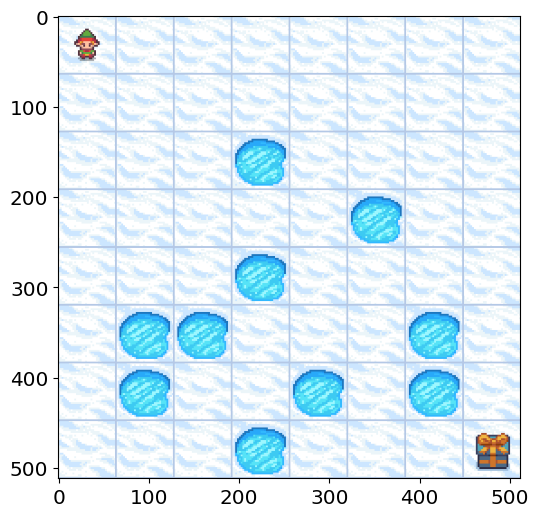

In [5]:
# Make the environment based on non-deterministic policy
env = gym.make('FrozenLake-v1', 
               map_name="8x8", 
               render_mode='rgb_array',
               is_slippery=True)

env.reset(seed = RANDOM_STATE)

img = plt.imshow(env.render())

In [6]:
# Define a function to generate episodes
def generate_episode(env):
    ### ------------------
    '''
    Args:
        env: Environment
    Return:
    List of states, actions, rewards
        states: list of states visited
    '''
    
    
    # initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # initialize the gym environment
    observation = env.reset()[0]
    
    while True:
        
        # append the states to the states list
        states.append(observation)
        
        # Sample the action from the environment
        # Its a random sample
        action = env.action_space.sample()
        actions.append(action)
        
        # Take Acton
        observation, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        done = terminated or truncated
        
        if done:
            #print (done, terminated , truncated, observation)
            break
    ###----------------------------           
    return states, actions, rewards

In [7]:
states, actions, rewards  = generate_episode(env)

In [8]:
states, actions, rewards

([0, 0, 1, 1, 2, 3, 4, 12, 13, 21],
 [0, 2, 3, 2, 1, 3, 0, 1, 0, 1],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

 Now that we learned how to generate an episode, we will see how to perform First Vist MC Prediction

In [9]:
def td_prediction(env, n_episodes):
    
    # Initialize value table as a dictionary for storing the values of each state
    value_table = np.random.rand(env.observation_space.n)*(-0.1)
    eligibility = np.zeros((env.observation_space.n))
    
    for _ in trange(n_episodes):
        
        # Play game to get sequence of actions and rewards
        states, _, rewards = generate_episode(env)
        #print (f'States: {states}\nRewards: {rewards}\n\n')
        
        # Then for each step, calculate State Value
        
        for t in range(len(states) - 1): # for all states in this sequence
            reward = rewards[t+1] # retrieve reward  
            next_state = states[t+1] # retrieve next_state
            cur_state = states[t]

            # Update eligibility
            eligibility *= LAMBD * GAMMA
            eligibility[cur_state] +=1

            # calculate TD Error
            td_error = reward + GAMMA * value_table[next_state] - value_table[cur_state]
            
            value_table[cur_state] = value_table[cur_state] + ALPHA * eligibility[cur_state] * td_error
            
    return value_table

In [10]:
value = td_prediction(env, n_episodes=EPISODES)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [04:40<00:00, 1782.27it/s]


In [11]:
value

array([ 0.38457495,  0.39250335,  0.41099087,  0.4392678 ,  0.47303161,
        0.51293423,  0.54455403,  0.56592448,  0.37654701,  0.38649486,
        0.40343815,  0.44207081,  0.46771866,  0.51418882,  0.56248365,
        0.58783052,  0.36401233,  0.36963543,  0.3758404 , -0.07838227,
        0.46291055,  0.52162243,  0.5979112 ,  0.65356524,  0.34203728,
        0.3551507 ,  0.36455861,  0.38016545,  0.39971409, -0.00851329,
        0.6677007 ,  0.7431112 ,  0.31385711,  0.34297111,  0.35243575,
       -0.08785805,  0.34759722,  0.44276115,  0.62077749,  0.94118544,
        0.25730705, -0.00160896, -0.06294491,  0.09320855,  0.24249779,
        0.27027254, -0.06277663,  1.36934293,  0.20489498, -0.00825286,
        0.0114998 ,  0.01513101, -0.02578655,  0.19112284, -0.03071353,
        1.54416885,  0.15003862,  0.09186834,  0.05006185, -0.08626137,
        0.0055724 ,  0.17030986,  0.1877906 , -0.01600641])

In [12]:
def fn_get_optimal_policy(grid, V):
    
    ### ------------------
    # Find the optimal policy corresponding to the optimal value function
    policy = np.zeros((grid.observation_space.n, grid.action_space.n))

    for state in range(grid.observation_space.n):
        # Create a vector of dimensionality same as the number of actions
        action_values = np.zeros(grid.action_space.n)

        for action in range(grid.action_space.n):

            for probability, next_state, reward, terminated in grid.unwrapped.P[state][action]:
                
                #action_values with one step look ahead
                action_values[action] += probability * (reward + GAMMA * V[next_state])
                

        # Choose the best action
        best_action = np.argmax(action_values)
        
        #print ('State :', state, action_values, best_action)

        policy[state][best_action] = 1.0

                
    ###------------------------------   

    return policy

In [13]:
policy = fn_get_optimal_policy(env, value)
#policy

In [14]:
plot_grid = value.reshape(8,8)
plot_grid.shape

(8, 8)

In [15]:
# Helper function to plot the grid

def fn_plot_heatmap(values, policy):
    
    fig, axes = plt.subplots(1,2)
    
    act = [action_mappings[action] for action in np.argmax(policy, axis=1)]
    
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip(act,values.ravel())]).reshape(8,8)
    
    #values = values.reshape(8,8)
    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn', ax=axes[0], cbar = False)
    
    axes[1].imshow(env.render())
    axes[1].set_axis_off()

    # Hide grid lines
    axes[1].grid(False)
    
    plt.show()

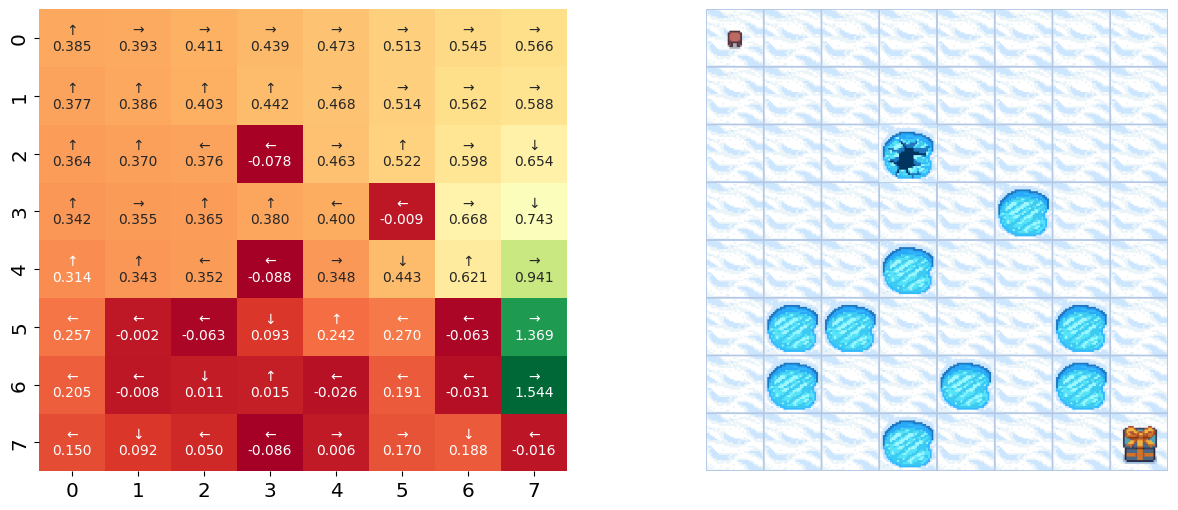

In [16]:
fn_plot_heatmap(plot_grid, policy)

In [17]:
#V, policy_slip = fn_value_iteration(env_slip)

n_iteration = 100


highscore = 0

data_row = []

for n_iter in trange(n_iteration):

    points = 0 # keep track of the reward each episode
    
    data_dict = {}
    
    for i_episode in range(20): # run 20 episodes
        #print ('_'*50)
        
        observation = env.reset()[0]
        
        while True: # run until episode is done
            #grid.render()
            
            action = np.argmax(policy[observation])
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            points += reward
            
            done  = terminated or truncated
            
            if done:
                #env.render()
                #print (observation, reward, terminated, truncated, info)

                if points > highscore: # record high score
                    highscore = points
                break
    data_dict['run'] = n_iter
    data_dict['Points']=  points
    data_row.append(data_dict)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.58it/s]


In [18]:
results_df =  pd.DataFrame(data_row)
results_df.head()

,run,Points
0,0,7.0
1,1,14.0
2,2,7.0
3,3,13.0
4,4,15.0


In [19]:
results_df.shape

(100, 2)

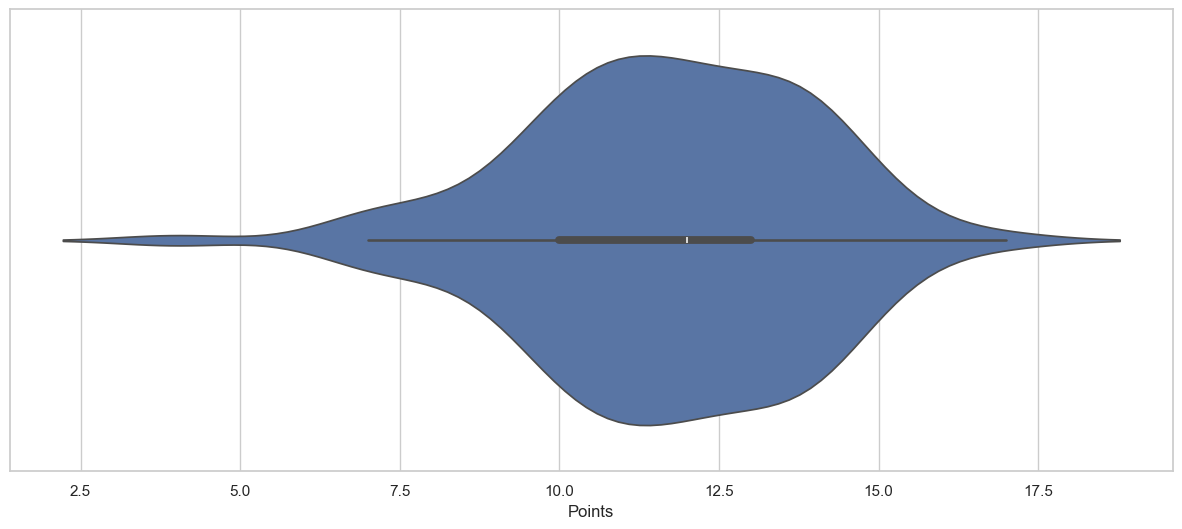

In [20]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=results_df["Points"])